In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from environment.gridworld import GridWorld
from agent.agent import DQNAgent
from visualize.new_grid_visualize import visualize_gridworld
from environment.grid_map import TileType
from environment.gridworld import Action

# 현재 state를 돌려주는 함수
def get_state_representation(grid_world, agent_pos):
    """
    GridWolrd의 현재 state를 DQN이 이해할 수 있는 형태로 변환
    - 현재 위치 좌표
    - 가장 가까운 목표 지점까지의 상대적 위치
    - 주변 5x5 그리드 정보
    """
    agent_x, agent_y = agent_pos
    grid_size = grid_world.grid_map.padded_size

    # state1: 현재 위치 좌표
    current_pos = np.array([agent_x, agent_y])

    # state2: 가장 가까운 목표 지점까지의 상대적 위치
    min_dist = float('inf')
    nearest_goal = (0, 0)

    # 방문하지 않은 목표 지점이 있는지 확인
    unvisited_goals = [goal for goal in grid_world.goals if goal not in grid_world.visited_goals]
    
    if unvisited_goals:  # 방문하지 않은 목표 지점이 있는 경우
        for goal in unvisited_goals:
            goal_x, goal_y = goal
            dist = abs(goal_x - agent_x) + abs(goal_y - agent_y)
            if dist < min_dist:
                min_dist = dist
                nearest_goal = goal
    
    goal_x, goal_y = nearest_goal
    rel_x = goal_x - agent_x
    rel_y = goal_y - agent_y

    # state3: 주변 5x5 그리드 정보
    local_grid = np.zeros((5, 5))
    for i in range(-2, 3):  # -2, -1, 0, 1, 2
        for j in range(-2, 3):
            nx, ny = agent_x + i, agent_y + j
            if grid_world.grid_map.get_tile_type(nx, ny) == TileType.EMPTY:
                local_grid[i+2, j+2] = 0    # 빈 공간은 0으로 표시
            elif grid_world.grid_map.get_tile_type(nx, ny) == TileType.CONSTRUCTION:
                local_grid[i+2, j+2] = 1    # 건물은 1로 표시
            elif grid_world.grid_map.get_tile_type(nx, ny) == TileType.WALL:
                local_grid[i+2, j+2] = 2  # 벽은 2로 표시
            elif (nx, ny) in grid_world.goals:
                local_grid[i+2, j+2] = 3  # 목표는 3로 표시

    # 모든 정보를 하나의 벡터로 결합
    state = np.concatenate([
        current_pos / grid_size,  # 정규화된 현재 위치
        np.array([rel_x, rel_y]) / grid_size,  # 정규화된 상대적 목표 위치
        local_grid.flatten()  # 5x5 그리드 정보를 1차원으로 변환
    ])

    return state

# 시나리오 1

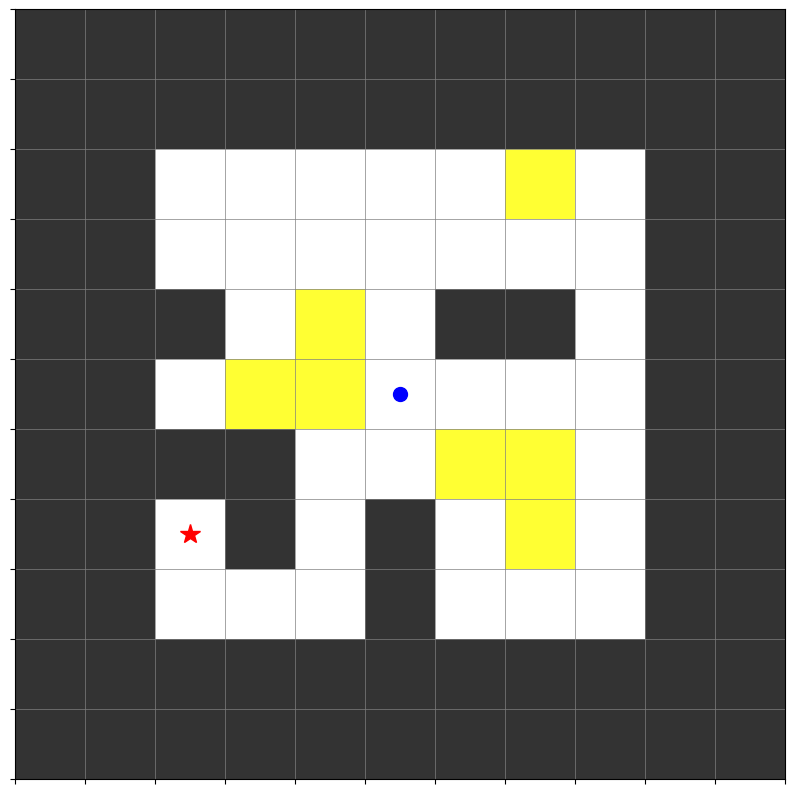

In [2]:
# 1. 환경 생성
grid_world = GridWorld(
    size=7,
    padding=2,
    seed=40,
    num_walls=5,
    num_construction=5,
    scenario_type="시나리오1"
)

# 2. DQN Agent 생성
state_size = 29     # 위에서 정의한 state의 크기
action_size = 4
agent = DQNAgent(state_size, action_size)

# 환경 시각화
visualize_gridworld(grid_world)

In [3]:
def train_dqn(grid_world, agent, episodes=1000, sync_interval=30):
    """
    DQN 에이전트 학습
    """
    success_count = 0  # 목표 도달 횟수
    total_steps = 0    # 총 스텝 수
    reward_history = []

    for episode in range(episodes):
        state = grid_world.reset()
        state_representation = get_state_representation(grid_world, state)
        done = False
        total_reward = 0
        step = 0

        while not done and step < 100:  # 최대 100 스텝
            # 행동 선택 및 실행
            action = agent.get_action(state_representation)
            next_state, reward, done = grid_world.step(Action(action))
            next_state_representation = get_state_representation(grid_world, next_state)

            # 에이전트 업데이트
            agent.update(state_representation, action, reward, next_state_representation, done)

            state = next_state
            state_representation = next_state_representation
            total_reward += reward
            step += 1

            if done:
                success_count += 1
                break

        total_steps += step

        # 주기적으로 타겟 네트워크 업데이트
        if episode % sync_interval == 0:
            agent.sync_qnet()

        reward_history.append(total_reward)
        if episode % 50 == 0:
            #print(f"Episode: {episode}, Total Reward: {total_reward:.2f}, Steps: {step}")
            success_rate = success_count / (episode + 1) * 100
            avg_steps = total_steps / (episode + 1)
            print(f"Episode: {episode} | Total Reward: {total_reward:.2f} | Steps: {step} | Success Rate: {success_rate:.1f}% | Average Steps: {avg_steps:.1f}")
            print("----------------------------------------------------------------------------------------")

    return reward_history

Episode: 0 | Total Reward: -6.72 | Steps: 100 | Success Rate: 0.0% | Average Steps: 100.0
----------------------------------------------------------------------------------------
Episode: 50 | Total Reward: -6.78 | Steps: 100 | Success Rate: 2.0% | Average Steps: 98.9
----------------------------------------------------------------------------------------
Episode: 100 | Total Reward: -1.23 | Steps: 48 | Success Rate: 2.0% | Average Steps: 98.9
----------------------------------------------------------------------------------------
Episode: 150 | Total Reward: -0.56 | Steps: 26 | Success Rate: 18.5% | Average Steps: 87.8
----------------------------------------------------------------------------------------
Episode: 200 | Total Reward: -0.57 | Steps: 39 | Success Rate: 35.8% | Average Steps: 75.2
----------------------------------------------------------------------------------------
Episode: 250 | Total Reward: 0.23 | Steps: 7 | Success Rate: 48.6% | Average Steps: 63.1
--------------

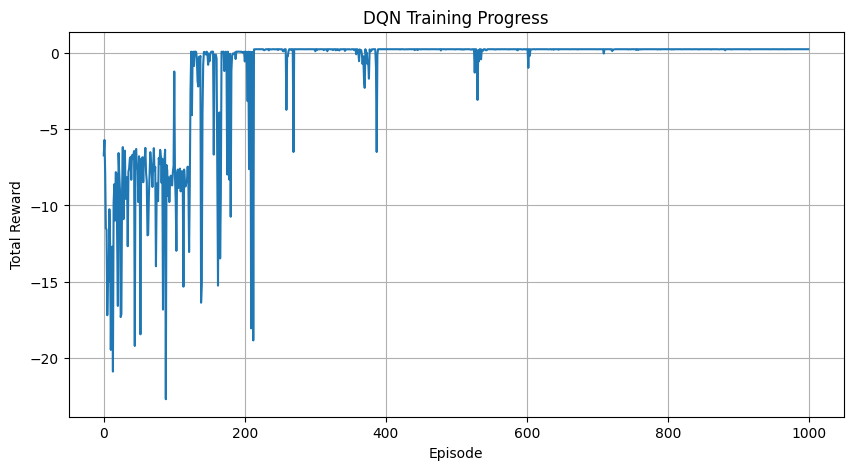

In [4]:
reward_history = train_dqn(grid_world, agent, episodes=1000, sync_interval=30)

plt.figure(figsize=(10, 5))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.grid(True)
plt.show()

In [5]:
import time

def test_agent(grid_world, agent, max_steps=100):
    """
    학습된 에이전트를 테스트하고 시각화합니다.
    테스트 시에는 epsilon을 0으로 설정하여 탐욕적 정책을 사용합니다.
    """
    # 테스트를 위해 epsilon을 0으로 설정
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    state = grid_world.reset()
    state_representation = get_state_representation(grid_world, state)
    done = False
    step = 0
    total_reward = 0

    print("테스트 시작!")
    print(f"시작 위치: {state}")

    try:
        while not done and step < max_steps:
            # 현재 상태 시각화
            visualize_gridworld(grid_world)

            # 행동 선택 및 실행
            action_idx = agent.get_action(state_representation)
            action = Action(action_idx)
            next_state, reward, done = grid_world.step(action)
            next_state_representation = get_state_representation(grid_world, next_state)

            # 결과 출력
            print(f"\n스텝 {step + 1}:")
            print(f"현재 위치: {state}")
            print(f"선택한 행동: {action}")
            print(f"다음 위치: {next_state}")
            print(f"보상: {reward}")

            state = next_state
            state_representation = next_state_representation
            total_reward += reward
            step += 1
            
            time.sleep(0.2)

            if done:
                print("\n목표 도달!")
                break

    finally:
        # 테스트 종료 후 원래의 epsilon 값으로 복원
        agent.epsilon = original_epsilon

    print(f"\n테스트 종료!")
    print(f"총 스텝 수: {step}")
    print(f"총 보상: {total_reward}")
    print(f"목표 도달 여부: {done}")

테스트 시작!
시작 위치: (5, 5)


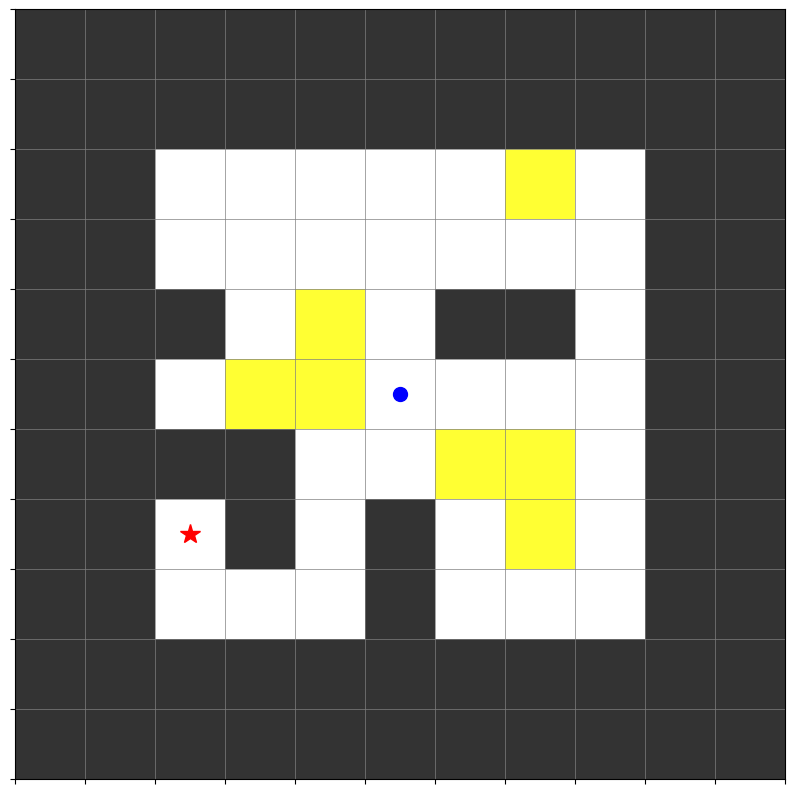


스텝 1:
현재 위치: (5, 5)
선택한 행동: Action.DOWN
다음 위치: (5, 6)
보상: -0.01


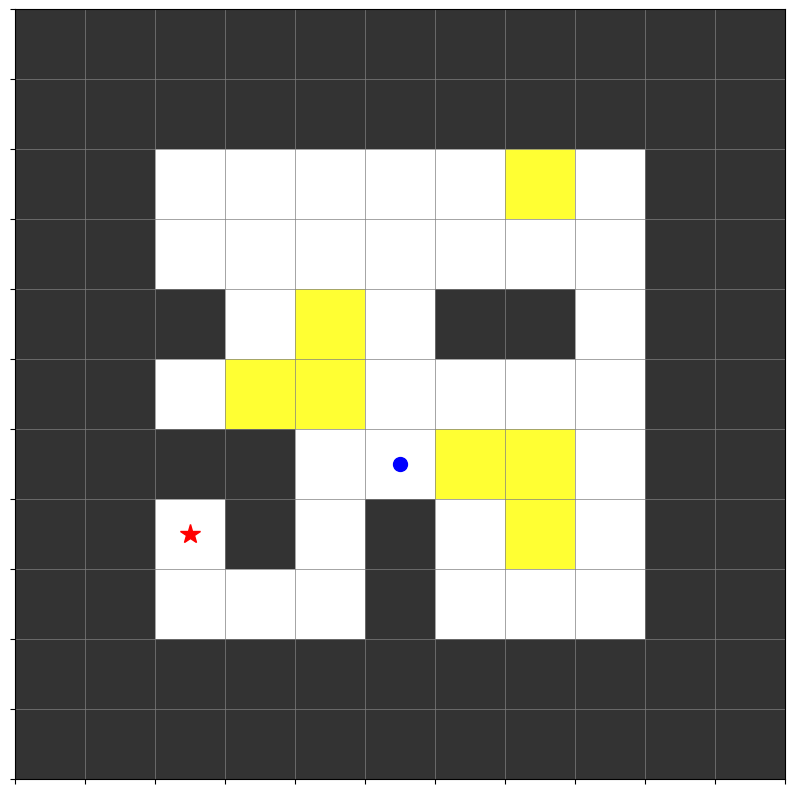


스텝 2:
현재 위치: (5, 6)
선택한 행동: Action.LEFT
다음 위치: (4, 6)
보상: -0.01


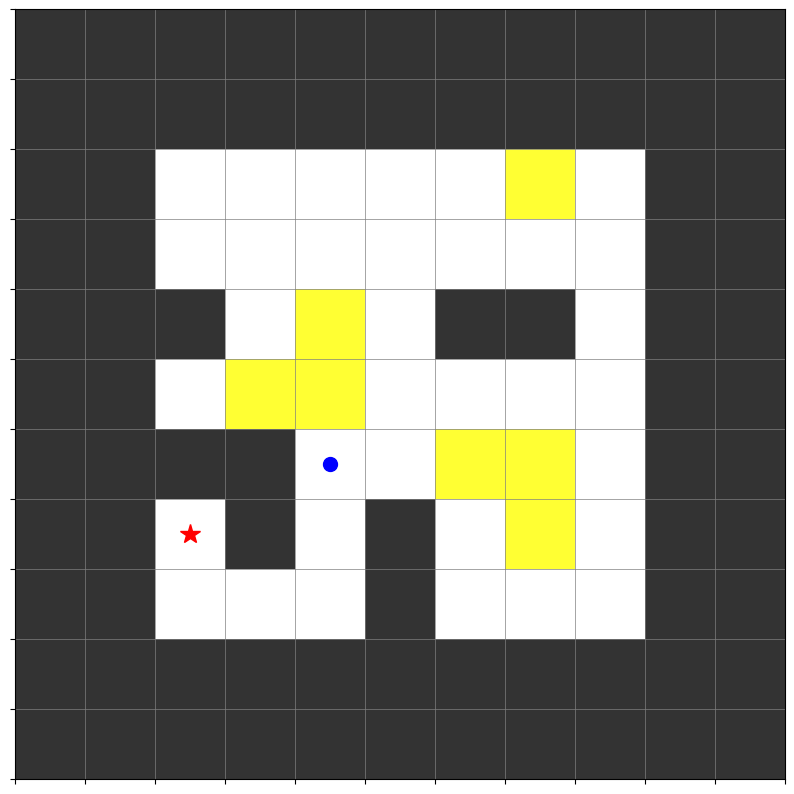


스텝 3:
현재 위치: (4, 6)
선택한 행동: Action.DOWN
다음 위치: (4, 7)
보상: -0.01


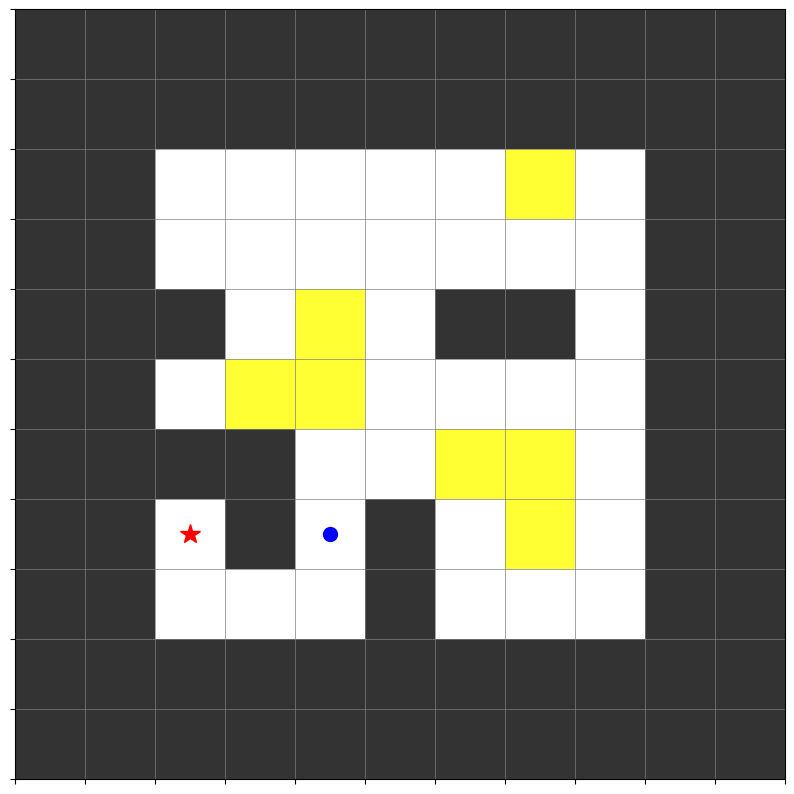


스텝 4:
현재 위치: (4, 7)
선택한 행동: Action.DOWN
다음 위치: (4, 8)
보상: -0.01


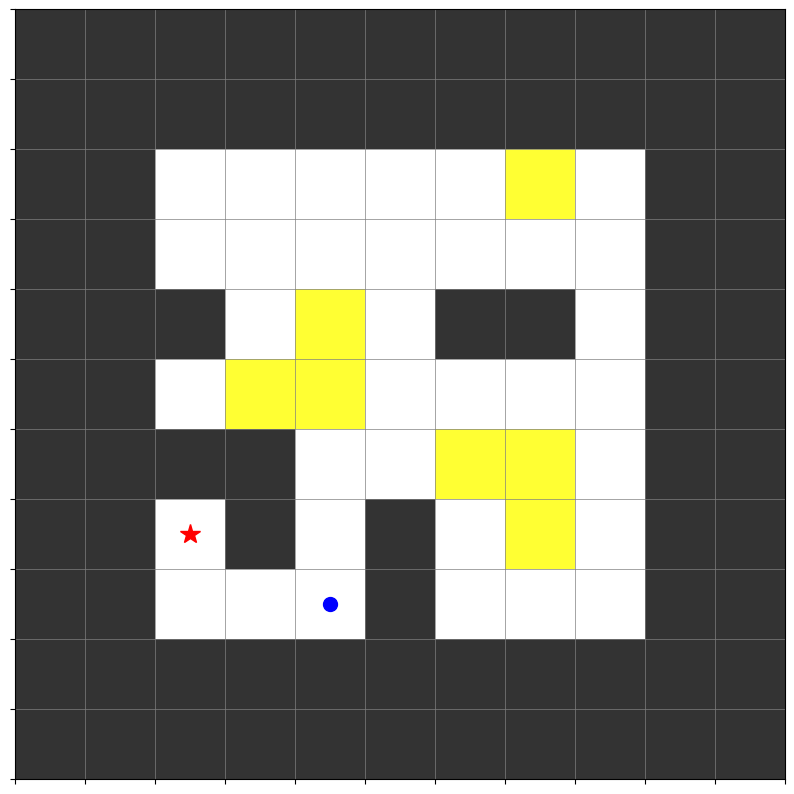


스텝 5:
현재 위치: (4, 8)
선택한 행동: Action.LEFT
다음 위치: (3, 8)
보상: -0.01


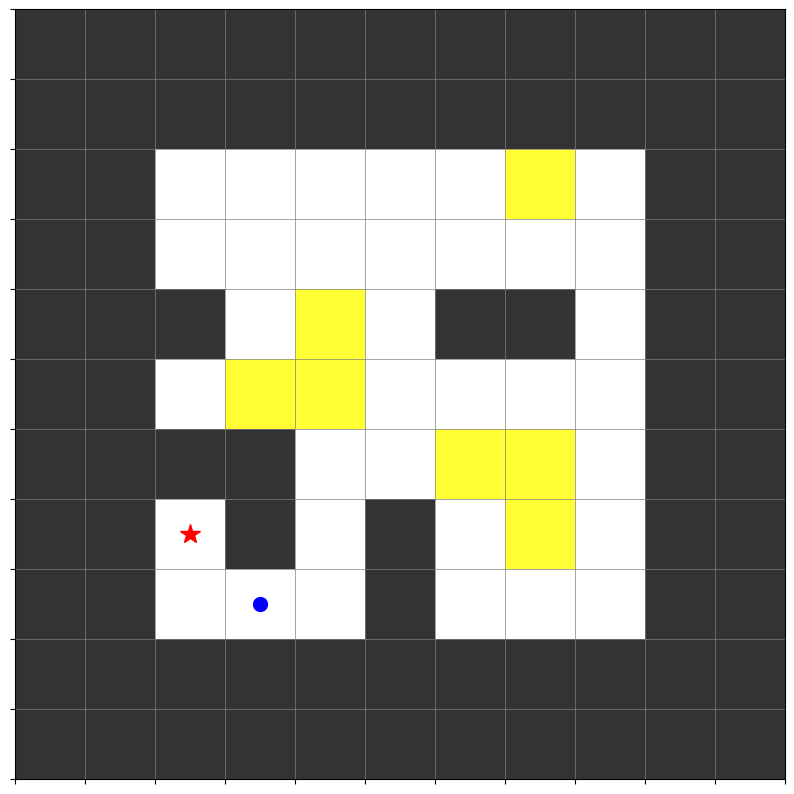


스텝 6:
현재 위치: (3, 8)
선택한 행동: Action.LEFT
다음 위치: (2, 8)
보상: -0.01


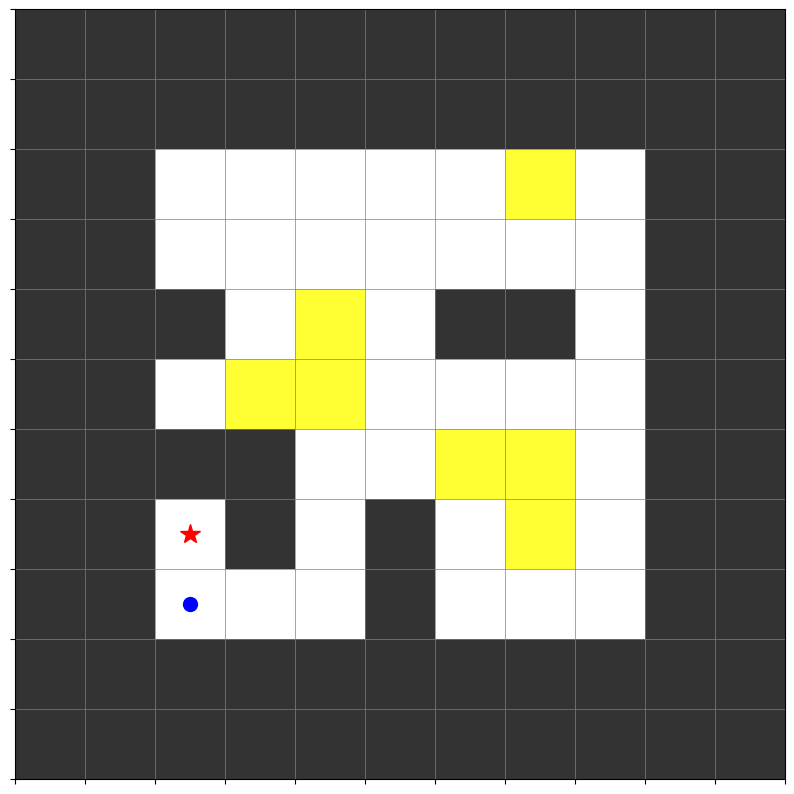


스텝 7:
현재 위치: (2, 8)
선택한 행동: Action.UP
다음 위치: (2, 7)
보상: 0.29

목표 도달!

테스트 종료!
총 스텝 수: 7
총 보상: 0.22999999999999998
목표 도달 여부: True


In [6]:
# 테스트 실행
test_agent(grid_world, agent)

# 시나리오 2

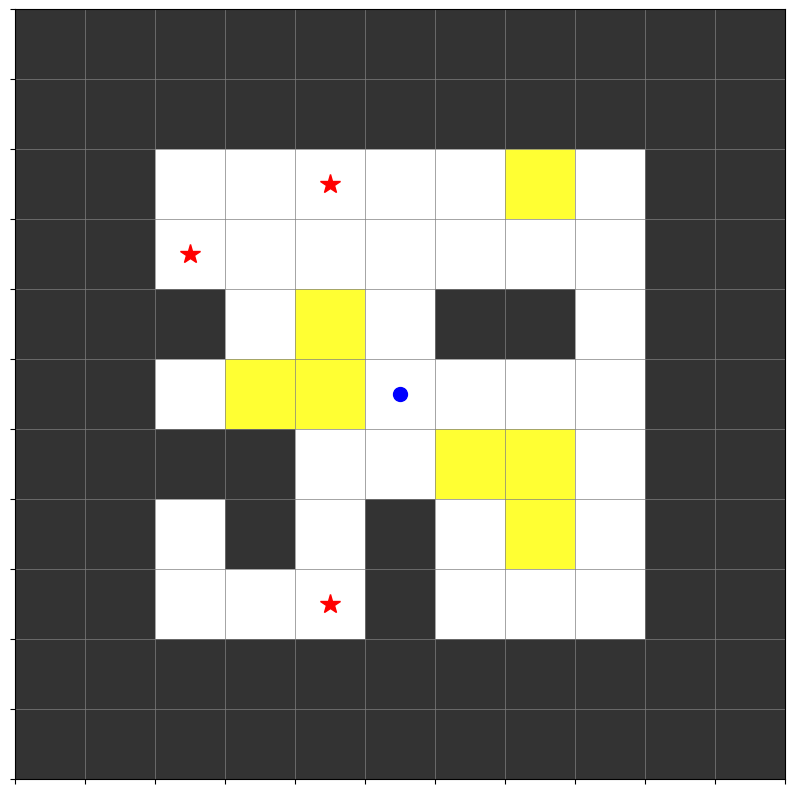

In [10]:
# 1. 환경 생성
grid_world = GridWorld(
    size=7,
    padding=2,
    seed=40,
    num_walls=5,
    num_construction=5,
    scenario_type="시나리오2"
)

# 2. DQN Agent 생성
state_size = 29     # 위에서 정의한 state의 크기
action_size = 4
agent = DQNAgent(state_size, action_size)

# 환경 시각화
visualize_gridworld(grid_world)

Episode: 0 | Total Reward: -0.49 | Steps: 26 | Success Rate: 100.0% | Average Steps: 26.0
----------------------------------------------------------------------------------------
Episode: 50 | Total Reward: 0.26 | Steps: 4 | Success Rate: 100.0% | Average Steps: 12.9
----------------------------------------------------------------------------------------
Episode: 100 | Total Reward: 0.13 | Steps: 7 | Success Rate: 100.0% | Average Steps: 9.0
----------------------------------------------------------------------------------------
Episode: 150 | Total Reward: 0.17 | Steps: 7 | Success Rate: 100.0% | Average Steps: 8.0
----------------------------------------------------------------------------------------
Episode: 200 | Total Reward: 0.26 | Steps: 4 | Success Rate: 100.0% | Average Steps: 7.1
----------------------------------------------------------------------------------------
Episode: 250 | Total Reward: 0.26 | Steps: 4 | Success Rate: 100.0% | Average Steps: 6.6
--------------------

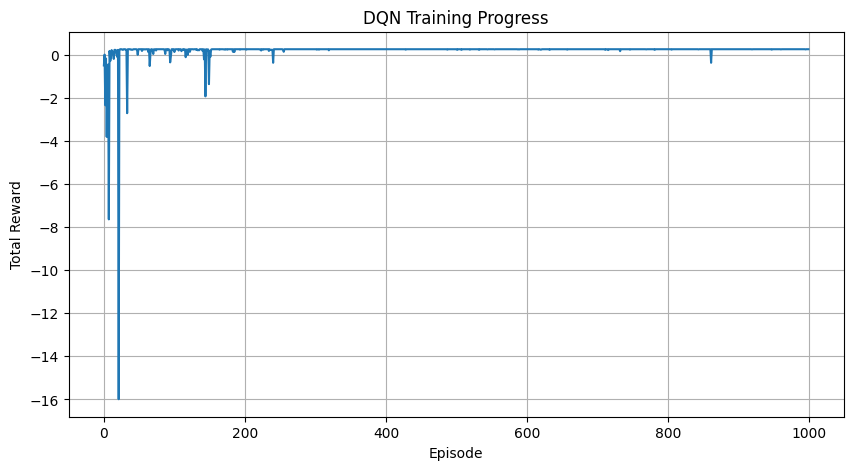

In [11]:
reward_history = train_dqn(grid_world, agent, episodes=1000, sync_interval=30)

plt.figure(figsize=(10, 5))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.grid(True)
plt.show()

테스트 시작!
시작 위치: (5, 5)


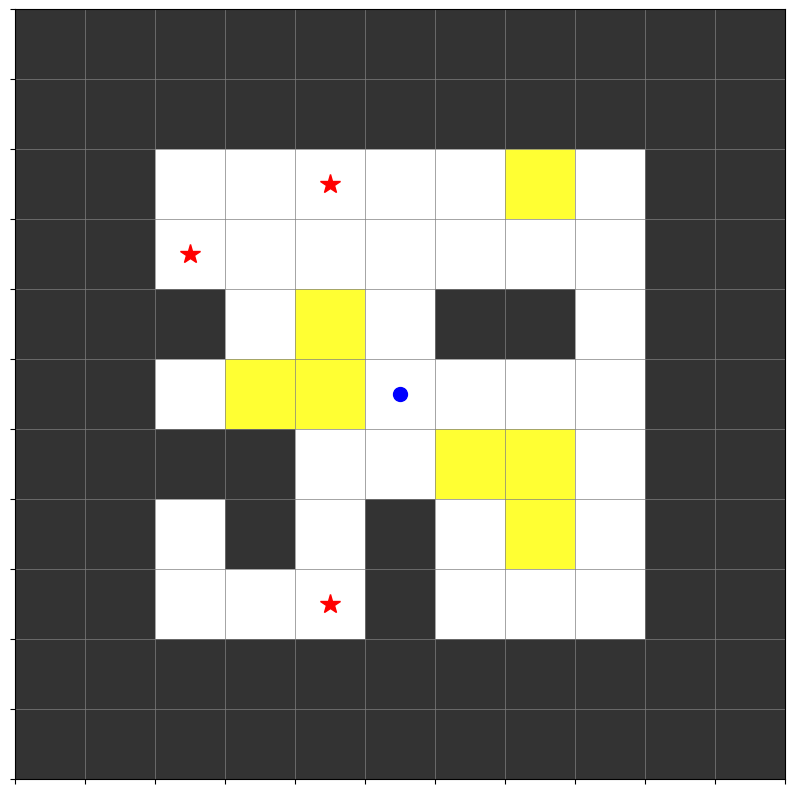


스텝 1:
현재 위치: (5, 5)
선택한 행동: Action.DOWN
다음 위치: (5, 6)
보상: -0.01


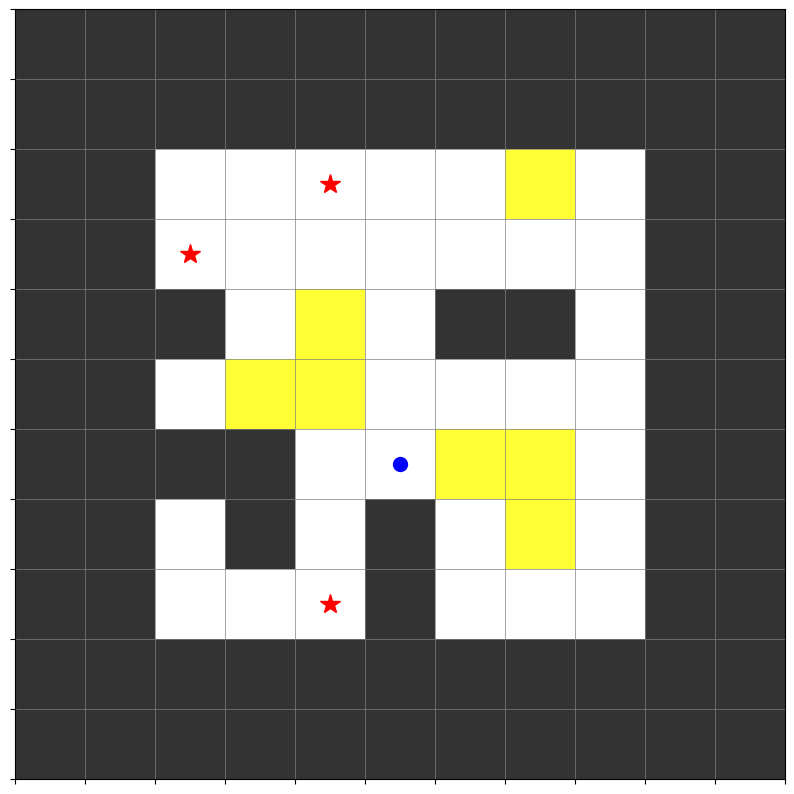


스텝 2:
현재 위치: (5, 6)
선택한 행동: Action.LEFT
다음 위치: (4, 6)
보상: -0.01


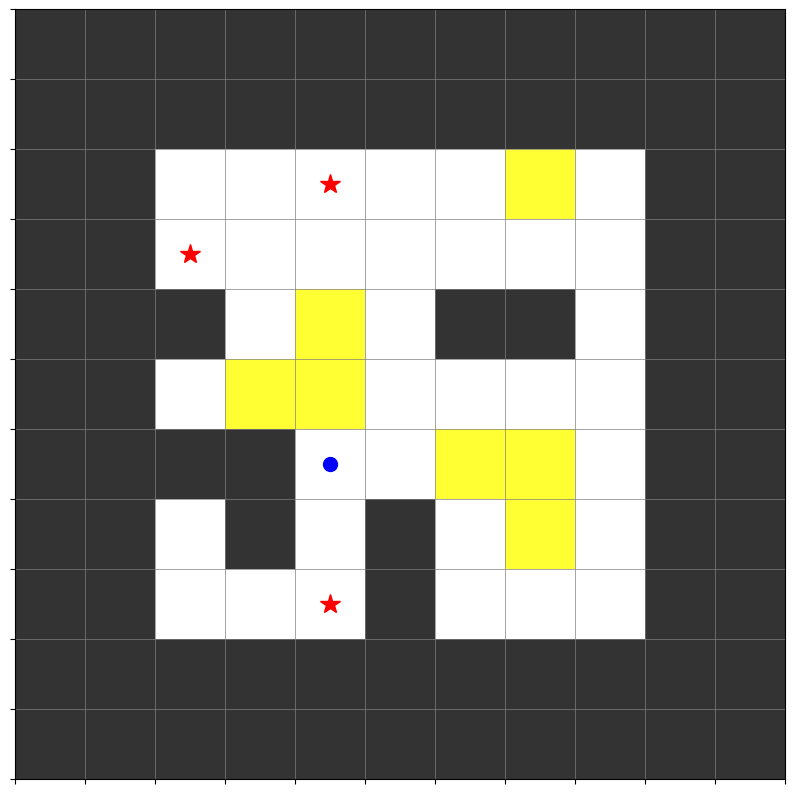


스텝 3:
현재 위치: (4, 6)
선택한 행동: Action.DOWN
다음 위치: (4, 7)
보상: -0.01


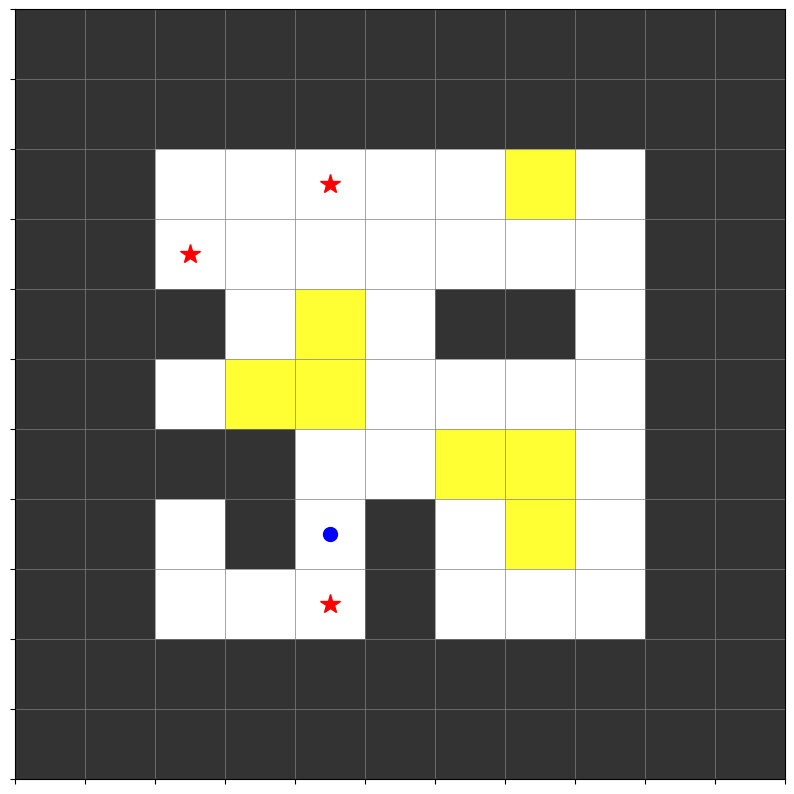


스텝 4:
현재 위치: (4, 7)
선택한 행동: Action.DOWN
다음 위치: (4, 8)
보상: 0.29

목표 도달!

테스트 종료!
총 스텝 수: 4
총 보상: 0.26
목표 도달 여부: True


In [12]:
# 테스트 실행
test_agent(grid_world, agent)

# 시나리오 3

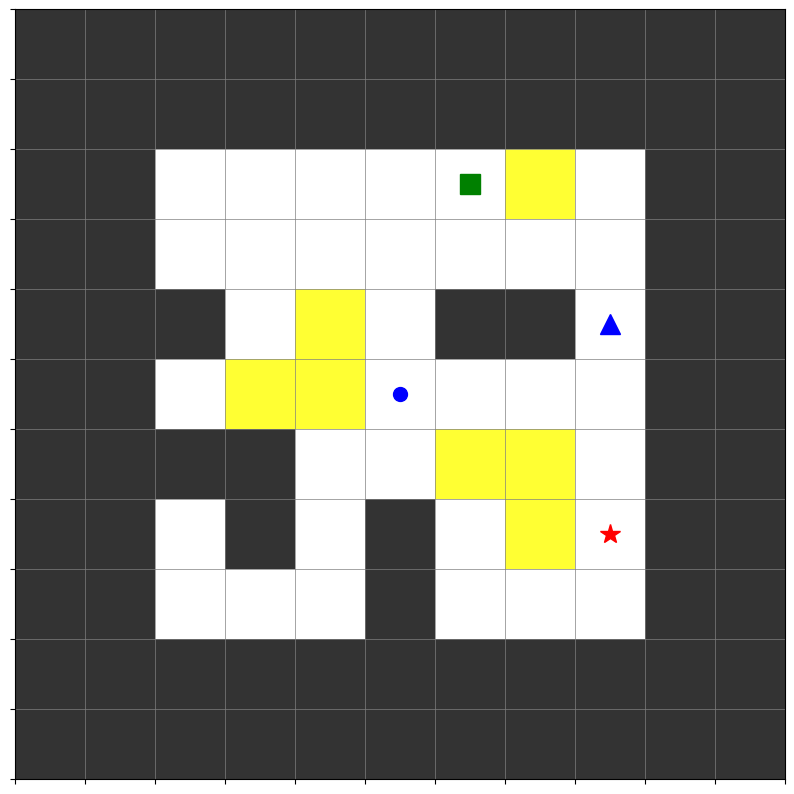

In [17]:
# 1. 환경 생성
grid_world = GridWorld(
    size=7,
    padding=2,
    seed=40,
    num_walls=5,
    num_construction=5,
    scenario_type="시나리오3"
)

# 2. DQN Agent 생성
state_size = 29     # 위에서 정의한 state의 크기
action_size = 4
agent = DQNAgent(state_size, action_size)

# 환경 시각화
visualize_gridworld(grid_world)

Episode: 0 | Total Reward: -5.25 | Steps: 100 | Success Rate: 0.0% | Average Steps: 100.0
----------------------------------------------------------------------------------------
Episode: 50 | Total Reward: 1.57 | Steps: 14 | Success Rate: 80.4% | Average Steps: 50.0
----------------------------------------------------------------------------------------
Episode: 100 | Total Reward: 1.66 | Steps: 11 | Success Rate: 90.1% | Average Steps: 36.8
----------------------------------------------------------------------------------------
Episode: 150 | Total Reward: 1.61 | Steps: 13 | Success Rate: 93.4% | Average Steps: 29.1
----------------------------------------------------------------------------------------
Episode: 200 | Total Reward: 1.63 | Steps: 14 | Success Rate: 94.5% | Average Steps: 26.1
----------------------------------------------------------------------------------------
Episode: 250 | Total Reward: 1.54 | Steps: 14 | Success Rate: 95.6% | Average Steps: 23.8
----------------

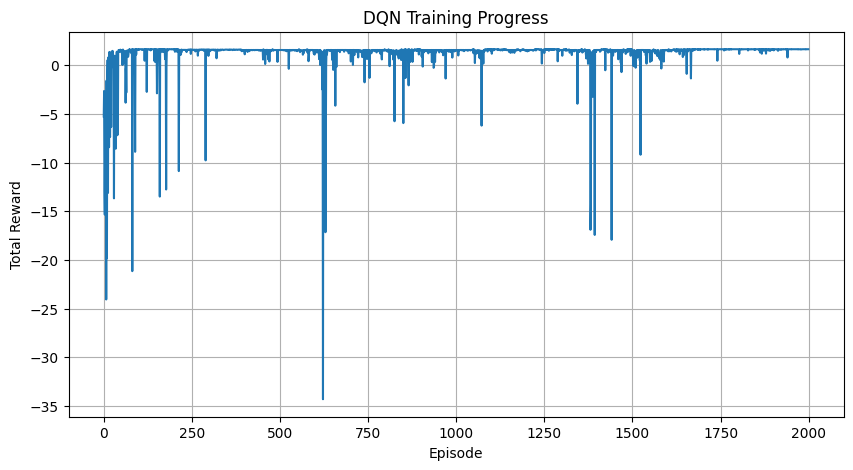

In [18]:
reward_history = train_dqn(grid_world, agent, episodes=2000, sync_interval=30)

plt.figure(figsize=(10, 5))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.grid(True)
plt.show()

테스트 시작!
시작 위치: (5, 5)


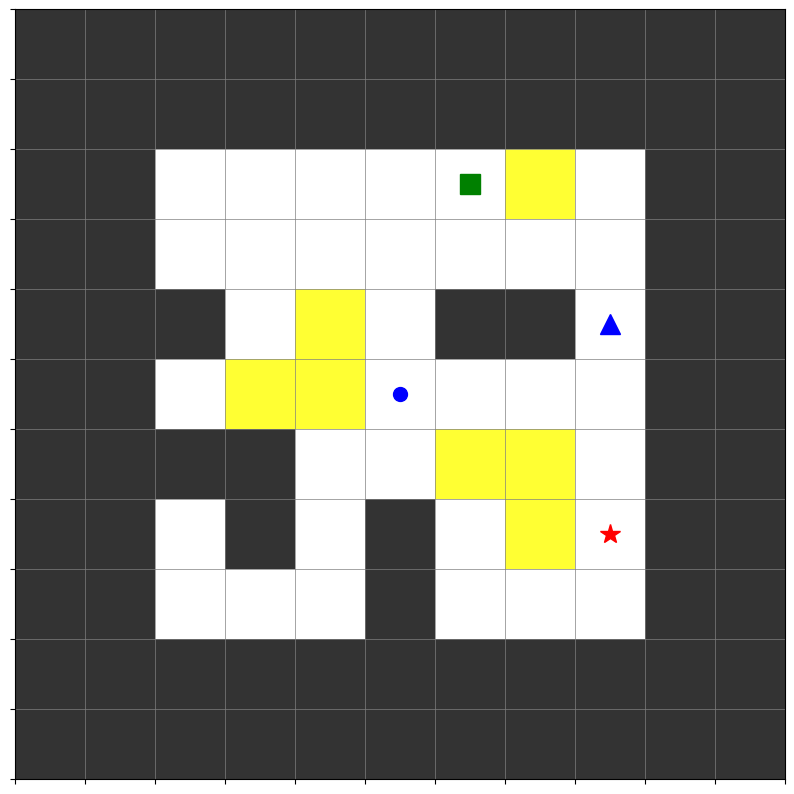


스텝 1:
현재 위치: (5, 5)
선택한 행동: Action.UP
다음 위치: (5, 4)
보상: -0.01


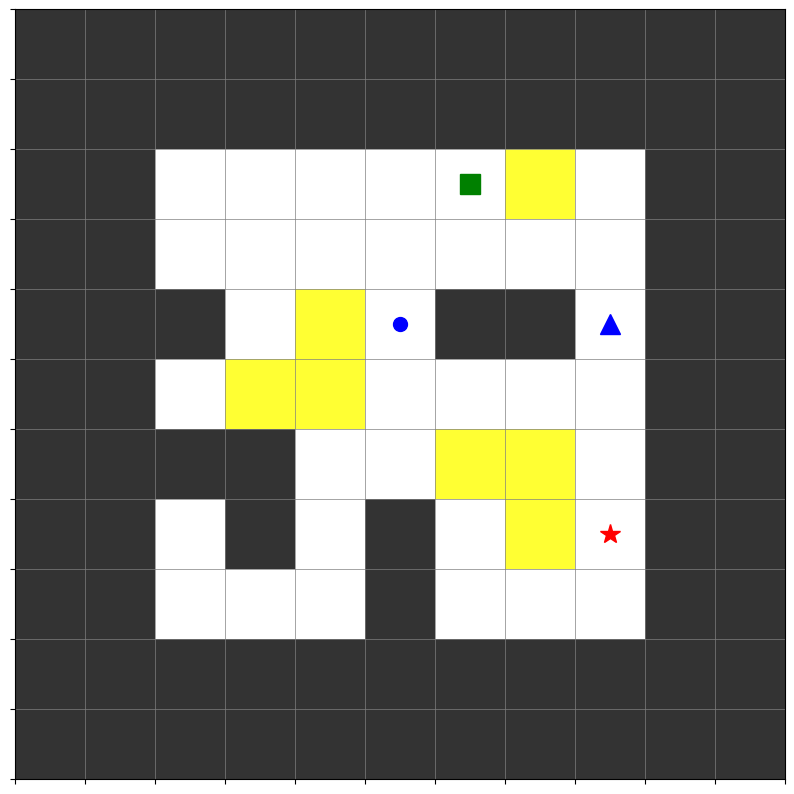


스텝 2:
현재 위치: (5, 4)
선택한 행동: Action.UP
다음 위치: (5, 3)
보상: -0.01


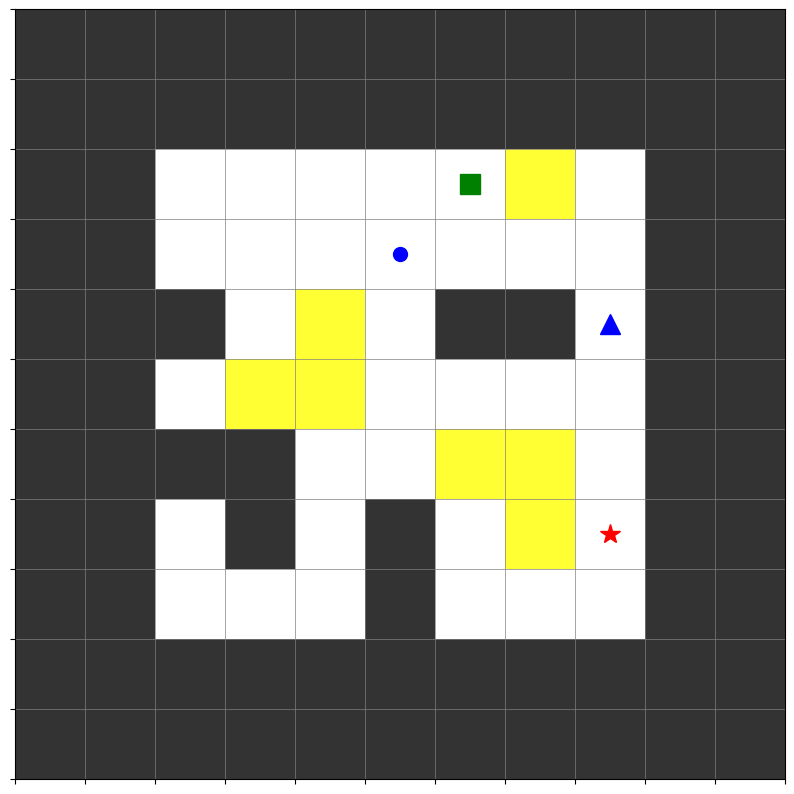


스텝 3:
현재 위치: (5, 3)
선택한 행동: Action.UP
다음 위치: (5, 2)
보상: -0.01


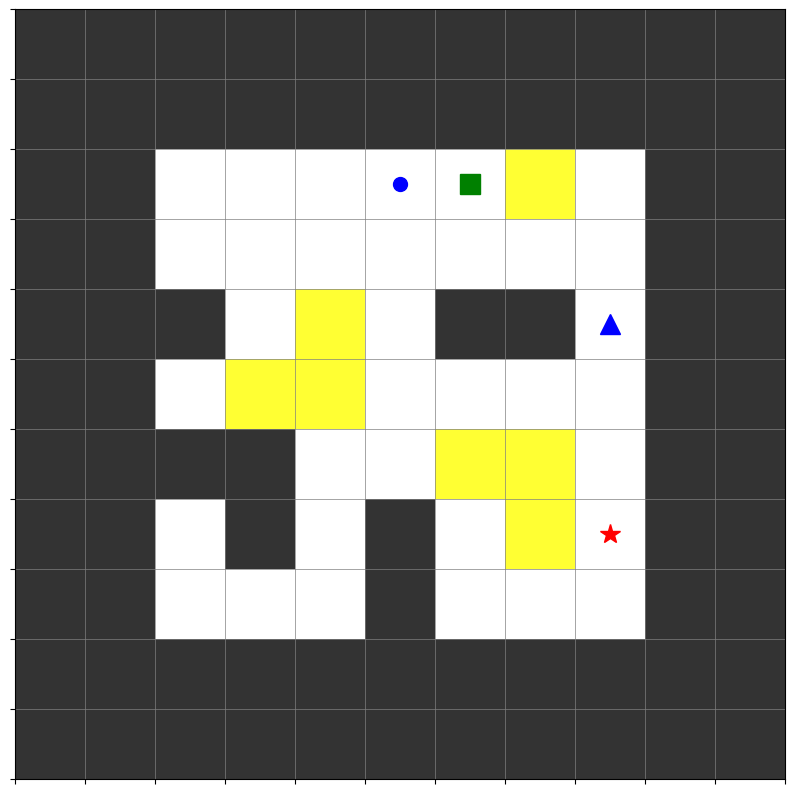


스텝 4:
현재 위치: (5, 2)
선택한 행동: Action.RIGHT
다음 위치: (6, 2)
보상: 0.29


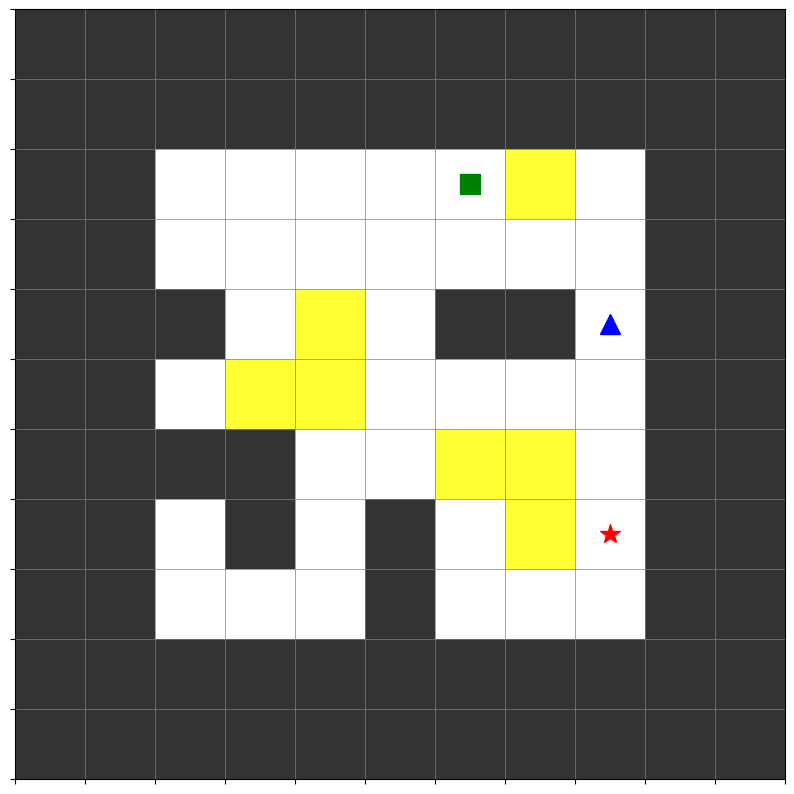


스텝 5:
현재 위치: (6, 2)
선택한 행동: Action.RIGHT
다음 위치: (7, 2)
보상: -0.04


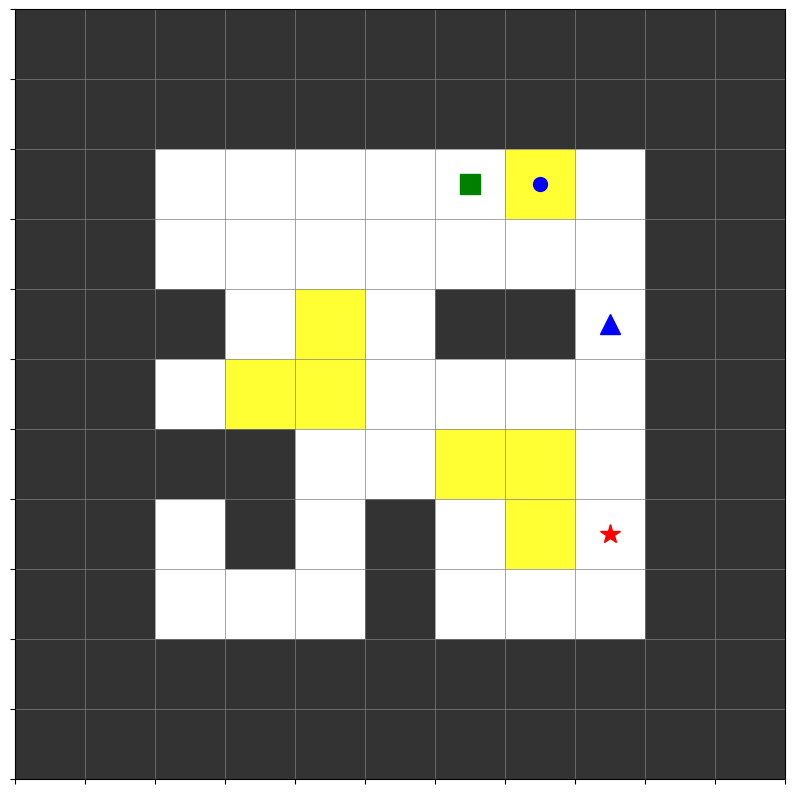


스텝 6:
현재 위치: (7, 2)
선택한 행동: Action.DOWN
다음 위치: (7, 3)
보상: -0.01


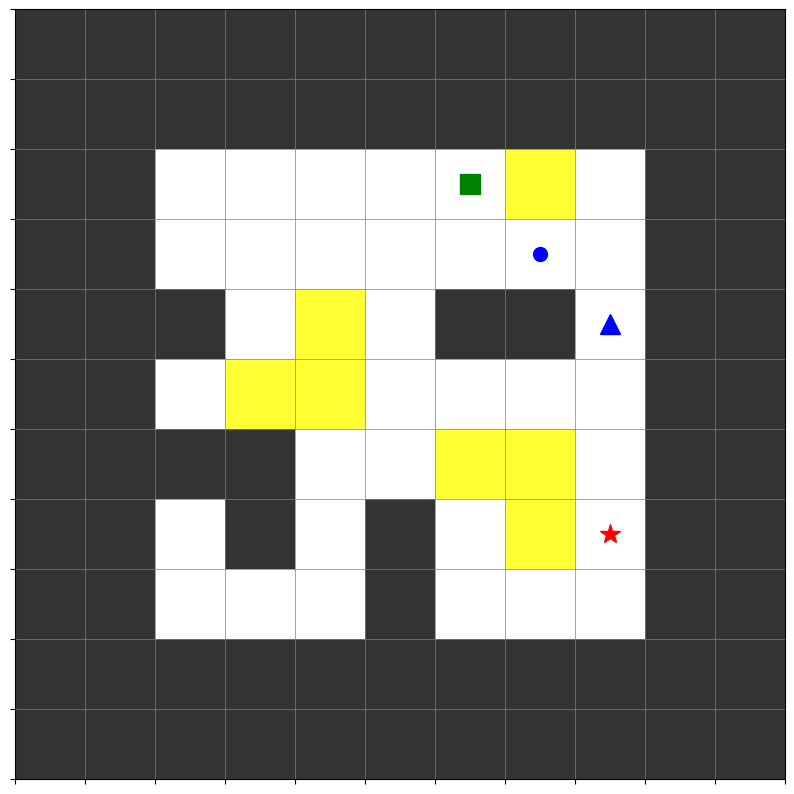


스텝 7:
현재 위치: (7, 3)
선택한 행동: Action.RIGHT
다음 위치: (8, 3)
보상: -0.01


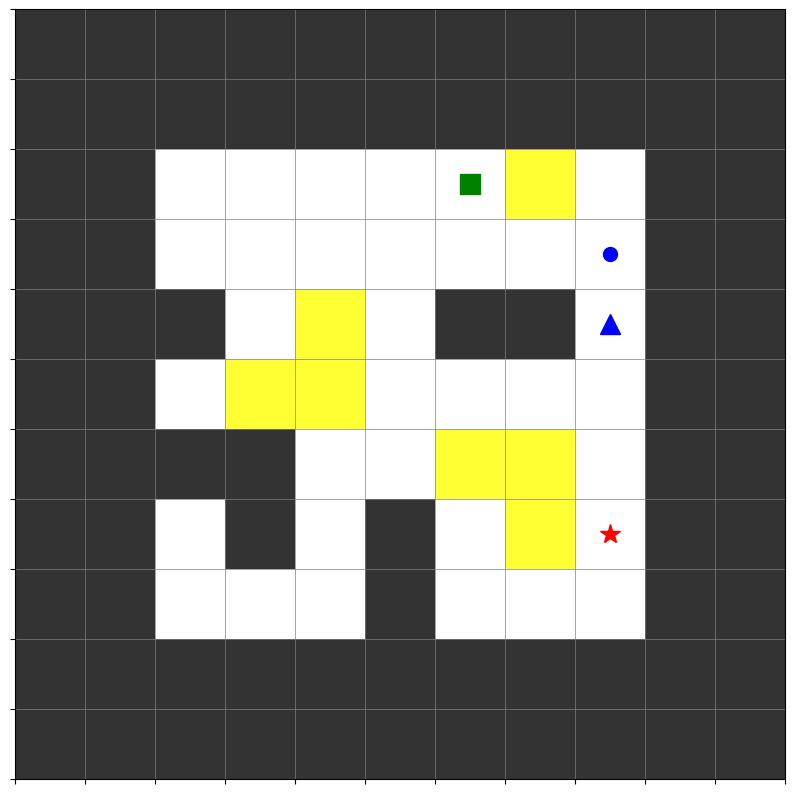


스텝 8:
현재 위치: (8, 3)
선택한 행동: Action.DOWN
다음 위치: (8, 4)
보상: 0.44000000000000006


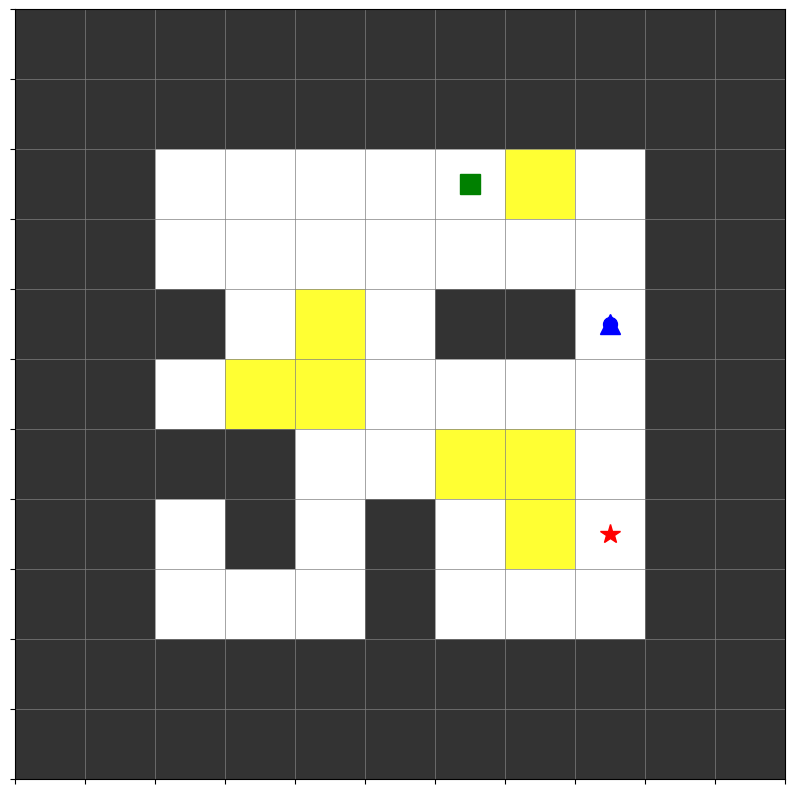


스텝 9:
현재 위치: (8, 4)
선택한 행동: Action.DOWN
다음 위치: (8, 5)
보상: -0.01


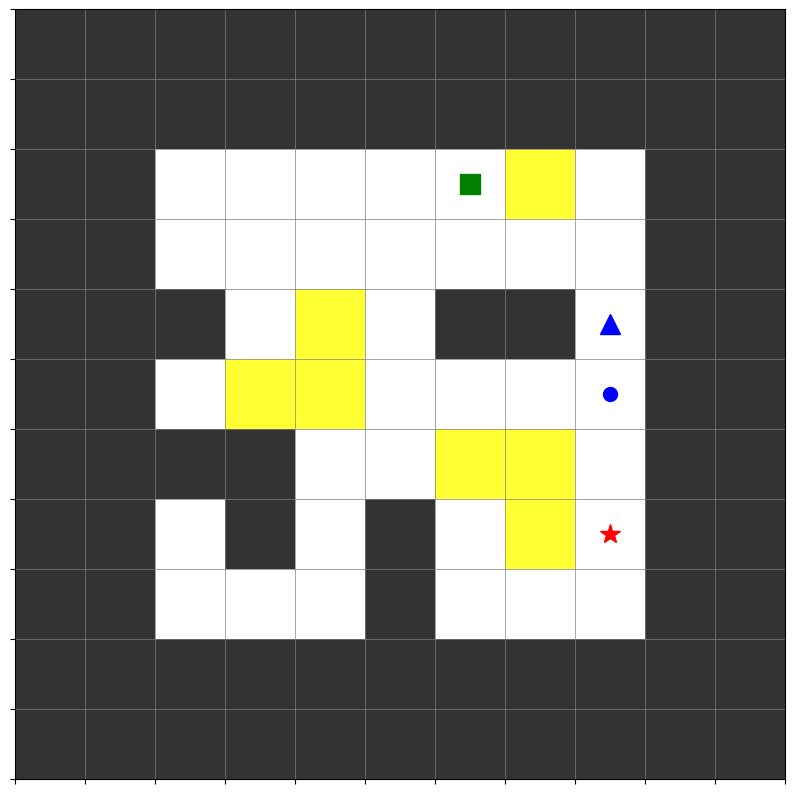


스텝 10:
현재 위치: (8, 5)
선택한 행동: Action.DOWN
다음 위치: (8, 6)
보상: -0.01


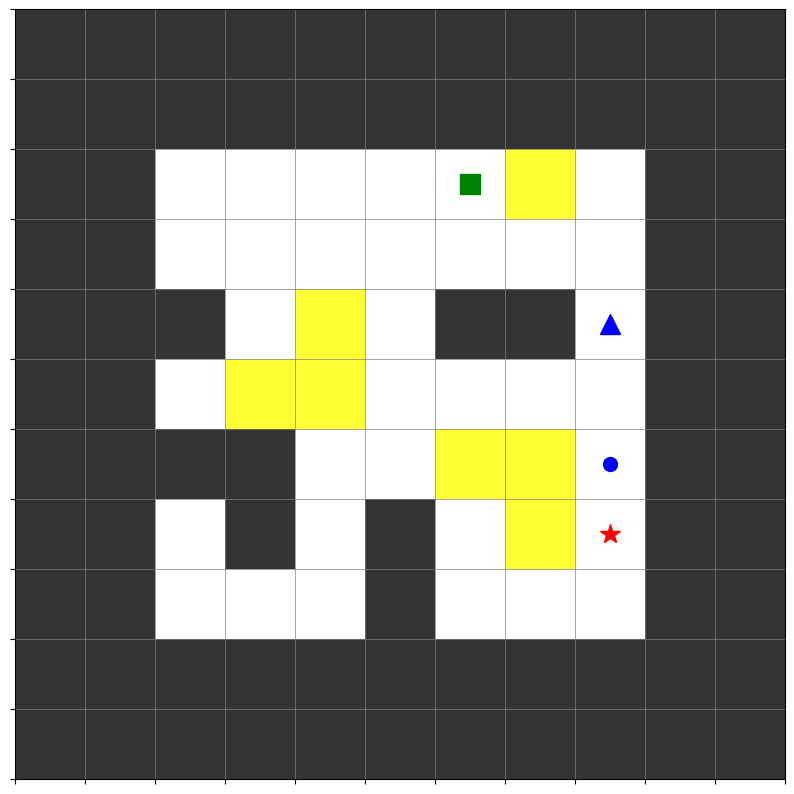


스텝 11:
현재 위치: (8, 6)
선택한 행동: Action.DOWN
다음 위치: (8, 7)
보상: 1.04

목표 도달!

테스트 종료!
총 스텝 수: 11
총 보상: 1.6600000000000001
목표 도달 여부: True


In [19]:
# 테스트 실행
test_agent(grid_world, agent)